In [10]:
from hyperedge_aggregator import compute_mean, mean_manual, compute_cov, compute_var
from torch_scatter import scatter_add, scatter_mean
import torch

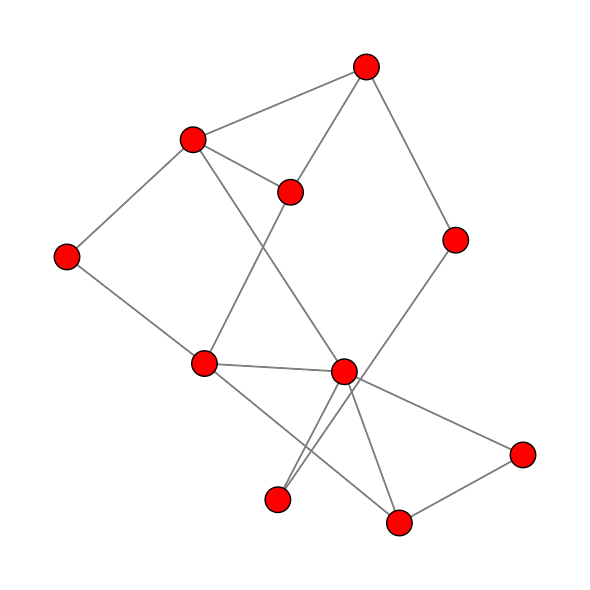

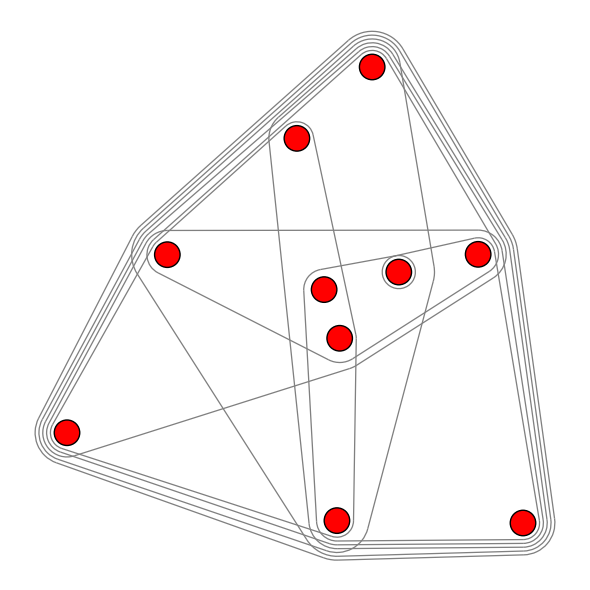

In [11]:
from dhg import Graph, Hypergraph

import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')

from hypgs.utils.data import get_hyperedge_index


# Create a random graph
g = nx.gnm_random_graph(10, 15)

G = Graph(g.number_of_nodes(), [e for e in g.edges])
HG = Hypergraph.from_graph_kHop(G, 2)
G.draw()
HG.draw()


In [12]:
edge_index = get_hyperedge_index(HG)
x = torch.randn(10, 3)

In [13]:
mu1 = mean_manual(x, edge_index)

In [14]:
mu2 = compute_mean(x, edge_index)

In [15]:
torch.isclose(mu1, mu2).all()

tensor(True)

In [16]:
mu1.shape

torch.Size([9, 3])

In [17]:
x.shape

torch.Size([10, 3])

In [18]:
var1 = compute_var(x, edge_index)

In [19]:
def compute_cov(x, edge_index):
    row, col = edge_index
    mean_features = scatter_mean(x[row], col, dim=0)
    xxT = torch.einsum('bi,bj->bij', x, x)
    xxT = xxT[row,...]
    shapes = xxT.size()
    xxT = xxT.reshape(-1, x.size(1) * x.size(1))
    mean_xxT = scatter_mean(xxT, col, dim=0).reshape(-1, x.size(1), x.size(1))
    cov = mean_xxT - torch.einsum('bi,bj->bij', mean_features, mean_features)
    return cov


In [20]:
cov2 = compute_cov(x, edge_index)

In [27]:
torch.tensor([torch.isclose(var1[i], torch.diagonal(cov2[i])).all() for i in range(var1.shape[0])]).all()

tensor(True)